In [1]:
## Titanic survival predictor - Support Vector Machine

# Collect and Load the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

# Load CSV from relative path
df = pd.read_csv('titanic/train.csv')


# Basic data inspection and exploration

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The data was collected from kaggle: https://www.kaggle.com/competitions/titanic. `head()` dsiplays the first 5 rows to give a bit of insight to the type of data to expect.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.shape

(891, 12)

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
df.index

RangeIndex(start=0, stop=891, step=1)

In [9]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Initial Insights
Just by doing a basic inspection and exploration of the data and we have some key insights that need attention.
1. 
The columns: Name, Sex, Ticket, Cabin, Embarked are all object dtype which meansthat if we plan to use this data in our model, we will need to encode it into a numerical dtype or remove it.
2. 
The columns: Age, Cabin, Embarked have missing values which mean we have to consider inputation or removal of these rows.
3. 
From df.describe() 38% of of passengers survived; Most passengers were in 2nd or 3rd class; Mean age: 29.7 & Median age: 28; SibSp / Parch both have low means (≈0.5 and 0.38) → Most passengers didn’t have many family members on board. Fare Mean ≈ 32, but Max = 512 → A few people paid very high fares (wealthy first-class travelers), creating a highly skewed distribution.

It is our job to decypher what this data means

In [11]:
#Understand the Data through visual represenntations

<Axes: title={'center': 'Survival Count'}, xlabel='Survived'>

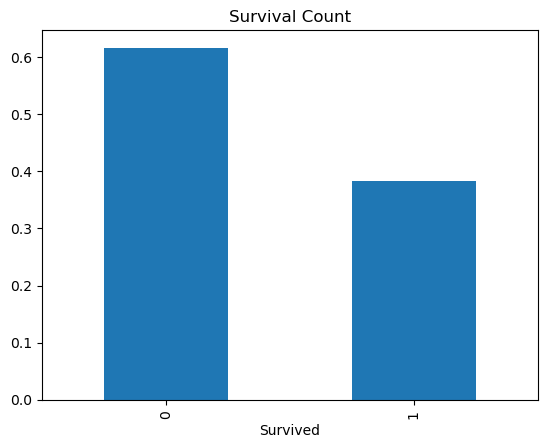

In [12]:
df['Survived'].value_counts(normalize=True).plot(kind='bar', title="Survival Count")

In [13]:
print(df.groupby('Sex')['Survived'].mean() , "\n")
print(df.groupby('Pclass')['Survived'].mean(), "\n")
print(df.groupby('Embarked')['Survived'].mean())

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


Pclass             -0.338481
Age                -0.077221
SibSp              -0.035322
Parch               0.081629
Fare                0.257307
Embarked_encoded    0.108669
Sex_encoded         0.543351
Name: Survived, dtype: float64


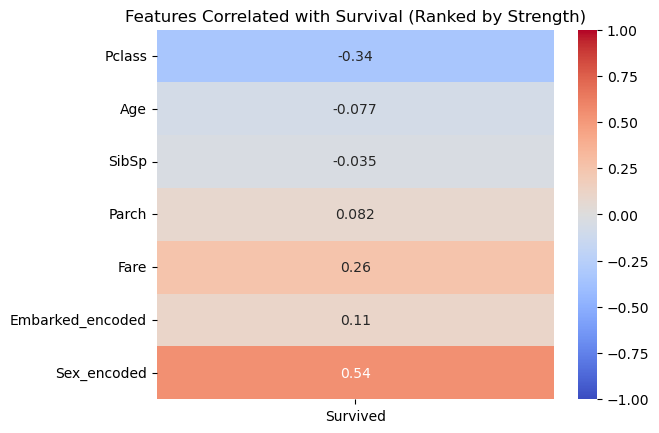

In [14]:
## Encode Sex as numerical values
df['Sex_encoded'] = df['Sex'].map({'male': 0, 'female': 1})

## Encode Embarcked as a numerical value
df['Embarked_encoded'] = df['Embarked'].map({'S': -1, 'C': 0, 'Q': 1})

## Create Correlation matrix of data
corr_matrix = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Embarked_encoded', 'Sex_encoded']].corr()
survived_corr = corr_matrix.loc['Survived'].drop('Survived')
print(survived_corr)

# Plot  heatmap
sea.heatmap(survived_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Features Correlated with Survival (Ranked by Strength)")
plt.show()
